# Langmuir isotherm predictions improved by FoKL-GPy in benchmark comparison of temperature-dependent model

---

## Abstract

Expanding *Langmuir isotherm predictions improved by FoKL-GPy in benchmark comparison* to include temperature, the site fraction at any temperature and pressure pair may be predicted.

---

## Contents

- 1
- 2
- 3

---

## Method

From *Langmuir isotherm predictions improved by FoKL-GPy in benchmark comparison*, the following is known and will provide the Gaussian process (GP) model $\mathbf{GP}$ trained on $\Delta$ as a function of the inverse of temperature $T$ and the natural logarithim of pressure $p$. The nomenclature is taken from [[1]](#1).

$\begin{equation}\tag{1} \mathbf{GP} = \{\Delta\ |\ T^{-1},\ \ln(p)\} \end{equation}$

$\begin{equation}\tag{2} \Delta = \ln(\sigma_1) \end{equation}$

$\begin{equation}\tag{3} \sigma_1 = \frac{q}{\mu(q_{max}-q)} \end{equation}$

$\begin{equation}\tag{4} \mu = \frac{p}{\sqrt{2 \pi M R T}} \end{equation}$

$\begin{equation}\tag{5} q_{max} = b \end{equation}$

The following is also known and will provide predictions of $q$, termed $q_{cal}$, from the GP.

$\begin{equation}\tag{6} q_{cal} = \frac{\sigma_{1, cal} q_{max} \mu}{1 + \sigma_{1, cal} \mu} \end{equation}$

$\begin{equation}\tag{7} \sigma_{1, cal} = \exp(\mathbf{GP}) \end{equation}$

The values of $q_{cal}$ found with the GP may then be compared to predictions from the Toth, UNILAN, Sips, and Langmuir isotherm models. The Langmuir predictions will be calculated here, but the rest have already been found in Table 2 of [[2]](#2) which is the source of the $q(T, p)$ experimental measurements. The data from the table has been saved as *Table2.txt*.

Values of $q_s$, which will serve as $q_{max}$ for scaling $\theta_{1, cal}$ so that the GP's comparison with each model is equivalent, were taken from Tables 4-6 for Toth, UNILAN, and Sips titled *TableN_Zeolite_13X.txt* where N is 4, 5, and 6. The other model parameters are included as well for plotting visual comparisons.

---

## Implementation:

Importing modules and defining constants:

In [1]:
import os
import sys
sys.path.append(os.path.join('..', '..', '..'))  # include local path (i.e., this package)
from src.FoKL import FoKLRoutines
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate


M = 0.0440095  # molecular weight of CO2, kg/mol
R = 8.31446261815324  # universal gas constant, J/(K*mol)

Loading and parsing the data (and removing last measurement of first experiment due to induced $\sigma_1 \lt 0$ for Langmuir model linear fit):

In [2]:
data = np.loadtxt(os.path.join('data', 'Table2.txt'), skiprows=2)  # experimental measurements q(T, p)
data = np.delete(data, 23, 0) # remove last datapoint (i=23) of first experiment (i.e., T = 273.15 K) as "outlier" because it results in negative 'sigma1 = eq3(q>0, mu>0, qmax>0)' when using positive b=qmax from Langmuir model linear fit

T = data[:, 0]  # K
p = data[:, 1]  * 1e3  # Pa
q = data[:, 2]  # mol/kg

# For benchmark comparison:
percent_error = data[:, 3:6]  # %, [Toth, UNILAN, Sips]

# Model parameters (for qs=qmax and for plotting):
params = [np.loadtxt(os.path.join('data', 'Table4_Zeolite_13X.txt'), skiprows=2),  # Toth
          np.loadtxt(os.path.join('data', 'Table5_Zeolite_13X.txt'), skiprows=2),  # UNILAN
          np.loadtxt(os.path.join('data', 'Table6_Zeolite_13X.txt'), skiprows=2)]  # Sips

# For indexing:
T_const = np.where(T[:-1] != T[1:])[0]  # indices where experiment ends (i.e., where next temperature changes)
T_const = np.insert(T_const + 1, [0, len(T_const)], [0, len(T)])  # indices where experiments begin (including "next" experiment enabling 'data[T_const[i]:T_const[i + 1], :]')
n = len(T_const) - 1  # number of experiments
nd = np.array(list(T_const[i + 1] - T_const[i] for i in range(n)))  # number of datapoints in each experiment


Applying a linear fit to $\frac{p}{q}$ vs. $p$ at each constant $T$ experiment in order to obtain the Langmuir isotherm model parameters as an additional benchmark comparison, and appending to ```params```.

In [3]:
p_q = p / q

a = np.array([])  # Langmuir isotherm parameter
b = np.array([])  # Langmuir isotherm parameter, =qmax
for i in range(n):
    j = T_const[i]  # index of beginning of experiment
    k = T_const[i + 1]  # index+1 of end of experiment
    
    coeffs = np.polyfit(p[j:k], p_q[j:k], 1)  # 'coeffs=[1/b, 1/(a*b)]' in 'p/q = p/b + 1/(a*b)' linear fit

    b = np.append(b, 1 / coeffs[0])
    a = np.append(a, 1 / coeffs[1] / b[i])

def eq3_from_ref2(qexp, qcal):
    """Equation 3 from [2]. Returns average percent deviations as in Tables 4-6."""
    k = len(qexp)  # = len(qcal)
    return 100 / k * sum(np.abs((qexp[j] - qcal[j]) / qexp[j]) for j in range(k))

avec = np.repeat(a, nd)
bvec = np.repeat(b, nd)

qcal_Langmuir = avec * bvec * p / (1 + avec * p)
dq_Langmuir = np.array(list(eq3_from_ref2(q[T_const[i]:T_const[i + 1]], qcal_Langmuir[T_const[i]:T_const[i + 1]]) for i in range(n)))  # average percent deviations per experiment

params.append(np.stack([T[T_const[:-1]], b, a, dq_Langmuir], axis=1))  # 'b=qmax' placed second because 'qs=qmax' is second for other parameters
nm = len(params)  # number of isotherm models (not including FoKL) for benchmark comparison

Defining equations:

In [4]:
def eq2(sigma1):
    """Delta"""
    return np.log(sigma1)

def eq3(q, mu, qmax):
    """sigma1"""
    return q / mu / (qmax - q)

def eq4(p, M, R, T):
    """mu"""
    return p / np.sqrt(2 * np.pi * M * R * T)

def eq6(sigma1, qmax, mu):
    """qcal"""
    return sigma1 * qmax * mu / (1 + sigma1 * mu)

Calculating training set $\{\Delta\ |\ T^{-1},\ \ln(p)\}$:

In [5]:
mu = eq4(p, M, R, T)
qmaxs = list(np.repeat(param[:, 1], nd) for param in params)  # list of vectors (with repeated values for each datapoint); each vector is for different isotherm model
sigma1s = list(eq3(q, mu, qmax) for qmax in qmaxs)  # list of vectors
Deltas = list(eq2(sigma1) for sigma1 in sigma1s)  # list of vectors

inv_T = 1 / T
ln_p = np.log(p)

Training $\mathbf{GP}$ for each set of $q_{max}$ taken from isotherm model parameters (but for now, just use Langmuir model):

In [6]:
qmax = qmaxs[-1]
sigma1 = sigma1s[-1]
Delta = Deltas[-1]

GP = FoKLRoutines.FoKL(kernel=1)
_ = GP.fit([inv_T, ln_p], Delta, clean=True)

/home/jacobpatrick/FoKL-GPy/docs/_dev/langmuir_isotherm/../../../src/FoKL/FoKLRoutines.py:299: UserWarning: 'inputs' was transposed. Ignore if more datapoints than input variables, else set 'AutoTranspose=False' to disable.
  warnings.warn("'inputs' was transposed. Ignore if more datapoints than input variables, else set "


[1, 52.341069095773946]
[2, 52.341069095773946]
[2, 2.556123194203124]
[3, 6.988173299573127]
[3, -18.710879861364205]
[4, -17.76666084373945]
[4, -17.580173738415453]
[4, -31.315513035312293]
[5, -31.44998257596756]
[5, -37.3670231036067]
[5, -40.583740739466904]
[6, -40.583740739466904]
[6, -40.583740739466904]
[6, -42.63183446152574]
[6, -45.58187553625649]
[7, -46.77085803144648]
[7, -54.72342075657342]
[7, -59.13642368584203]
[7, -59.20679256183922]
[8, -59.20679256183922]
[8, -59.20679256183922]
[8, -63.75805808635728]
[8, -64.31089919297594]
[8, -65.13429905406136]
[9, -65.13429905406136]
[9, -66.39306035674569]
[9, -71.93805534376986]
[9, -77.10530218723875]
[9, -78.09505305133834]
[10, -78.09505305133834]
[10, -78.09505305133834]
[10, -78.09505305133834]


Print model's interaction matrix as sanity check confirming dependence on both $(T^{-1},\ \ln(p))$:

In [7]:
print(GP.mtx)

[[0. 1.]
 [1. 0.]
 [0. 2.]
 [2. 0.]
 [1. 2.]
 [2. 1.]
 [0. 3.]
 [2. 2.]
 [1. 3.]
 [0. 4.]
 [2. 3.]
 [1. 4.]
 [0. 5.]
 [1. 5.]
 [0. 6.]
 [3. 4.]
 [2. 5.]
 [1. 6.]
 [0. 7.]
 [2. 6.]
 [1. 7.]
 [0. 8.]
 [3. 6.]
 [2. 7.]
 [1. 8.]
 [8. 1.]
 [0. 9.]]


Calculate $q_{cal}$ predictions for comparison:

In [8]:
Delta_cal = GP.evaluate()
sigma1_cal = np.exp(Delta_cal)
qcal = eq6(sigma1_cal, qmax, mu)

Plot for visual validation:

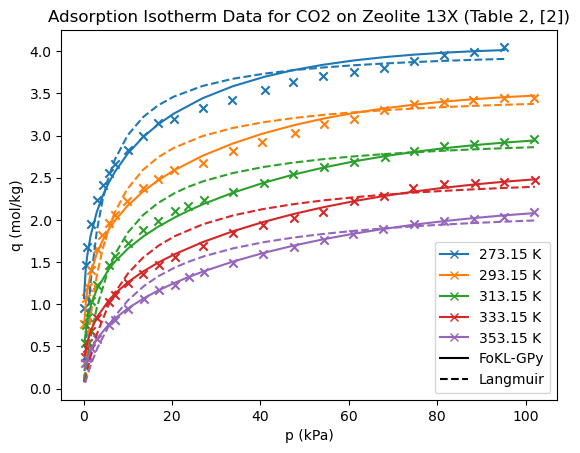

In [9]:
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D


colors = mcolors.TABLEAU_COLORS  # dictionary of all colors
colors = list(colors.values())[:n]  # first 'n' colors, one per experiment
markers = ['x'] * n
labels = list(f"{np.round(T[T_const[i]], 2)} K" for i in range(n))

p_kPa = p * 1e-3
fig, ax = plt.subplots()
for i in range(n):
    j = T_const[i]
    k = T_const[i + 1]

    plt.scatter(p_kPa[j:k], q[j:k], color=colors[i], marker=markers[i])  # experimental measurements
    plt.plot(p_kPa[j:k], qcal[j:k], color=colors[i])  # GP model
    plt.plot(p_kPa[j:k], qcal_Langmuir[j:k], '--', color=colors[i])  # Langmuir model

ax.set_xlabel('p (kPa)')
ax.set_ylabel('q (mol/kg)')
ax.set_title('Adsorption Isotherm Data for CO2 on Zeolite 13X (Table 2, [2])')

legend_elements = list(Line2D([0], [0], marker=markers[i], color=colors[i], label=labels[i]) for i in range(n)) \
                  + [Line2D([0], [0], color='k', label='FoKL-GPy'), Line2D([0], [0], ls='--', color='k', label='Langmuir')]
ax.legend(handles=legend_elements, loc='lower right')

Percent error STUFF:

## References

[1] Langmuir 1918

[2]
-  https://pubs.acs.org/doi/10.1021/je020050e
    - gold mine of data -- Tables 2-3
